# Crypto IV–RV Straddle Carry Research Notebook




Goal: Quantify and backtest a simple weekly straddle carry strategy on BTC using the spread between Implied Volatility (IV) and Realized Volatility (RV).

Key ideas:
- Use trailing 7-day realized volatility (RV) as information available at the time of the trade.
- Use implied volatility (IV) from a Deribit volatility index as a proxy for option market expectations.
- Build a weekly dataset of Friday snapshots.
- Construct a trading signal based only on information available on the snapshot date.
- Evaluate strategy performance using what actually happens over the next week (next 7-day RV).

This notebook is designed to avoid look-ahead bias:
- Signals are based on IV and trailing RV.
- Future RV is only used to evaluate PnL, not to decide the trade.


In [1]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import timedelta

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)

ANNUAL_DAYS = 365
START_DATE = "2023-01-01"


In [2]:

!pip install yfinance -q
import yfinance as yf

btc = yf.download("BTC-USD", start=START_DATE, interval="1d")

if isinstance(btc.columns, pd.MultiIndex):
    btc.columns = btc.columns.get_level_values(0)

btc = btc.reset_index()[["Date", "Close"]].rename(columns={"Date": "date", "Close": "close"})
btc["date"] = pd.to_datetime(btc["date"]).dt.date
btc = btc.reset_index(drop=True)

btc.head()


/tmp/ipython-input-812844850.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start=START_DATE, interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,date,close
0,2023-01-01,16625.080078
1,2023-01-02,16688.470703
2,2023-01-03,16679.857422
3,2023-01-04,16863.238281
4,2023-01-05,16836.736328


In [3]:

btc["log_ret"] = np.log(btc["close"]).diff()

btc["rv_trailing_7d_ann"] = np.sqrt(ANNUAL_DAYS) * btc["log_ret"].rolling(7).std()

btc.tail(10)


Price,date,close,log_ret,rv_trailing_7d_ann
1051,2025-11-17,92093.875000,-0.022368,0.381403
1052,2025-11-18,92948.875000,0.009241,0.425158
1053,2025-11-19,91465.992188,-0.016082,0.425018
1054,2025-11-20,86631.898438,-0.054299,0.512266
1055,2025-11-21,85090.687500,-0.017950,0.422329
1056,2025-11-22,84648.359375,-0.005212,0.370388
1057,2025-11-23,86805.007812,0.025159,0.482436
1058,2025-11-24,88270.562500,0.016742,0.511347
1059,2025-11-25,87341.890625,-0.010576,0.495043
1060,2025-11-27,91222.632812,0.043473,0.614722


In [4]:

btc["weekday"] = pd.to_datetime(btc["date"]).dt.weekday
friday_idx = btc.index[btc["weekday"] == 4].tolist()

len(friday_idx), friday_idx[:10]


(151, [5, 12, 19, 26, 33, 40, 47, 54, 61, 68])

In [5]:
rows = []

for idx in friday_idx:

    rv_trailing = btc.loc[idx, "rv_trailing_7d_ann"]
    if pd.isna(rv_trailing):
        continue

    start = idx + 1
    end = idx + 7

    if end >= len(btc):
        continue

    rvs_forward = btc.loc[start:end, "log_ret"].dropna()
    if len(rvs_forward) < 7:
        continue

    rv_next = np.sqrt(ANNUAL_DAYS) * rvs_forward.std(ddof=1)

    price_start = btc.loc[idx, "close"]
    price_end = btc.loc[end, "close"]

    btc_ret_next_7d = np.log(price_end / price_start)

    rows.append({
        "snapshot_friday": str(btc.loc[idx, "date"]),
        "rv_trailing_7d_ann": float(rv_trailing),
        "rv_next_7d_ann": float(rv_next),
        "btc_ret_next_7d": float(btc_ret_next_7d),
    })

weekly = pd.DataFrame(rows)
weekly.head(10)


,snapshot_friday,rv_trailing_7d_ann,rv_next_7d_ann,btc_ret_next_7d
0,2023-01-13,0.415445,0.637048,0.130131
1,2023-01-20,0.637048,0.206541,0.017580
2,2023-01-27,0.206541,0.460880,0.015930
3,2023-02-03,0.460880,0.405136,-0.079781
4,2023-02-10,0.405136,0.723039,0.126287
5,2023-02-17,0.723039,0.311055,-0.057276
6,2023-02-24,0.311055,0.441854,-0.036678
7,2023-03-03,0.441854,0.451643,-0.102343
8,2023-03-10,0.451643,0.762515,0.306365
9,2023-03-17,0.762515,0.571117,0.002526


In [6]:


DERIBIT_DVOL_ENDPOINT = "https://www.deribit.com/api/v2/public/get_volatility_index_data"

def get_dvol(date_str, currency="BTC"):
    """
    Fetch the most recent DVOL close value around a given date.
    Returns the annualized implied volatility as a decimal (for example, 0.60 for 60%).
    """
    try:
        ts = pd.Timestamp(date_str).tz_localize("UTC")
        end_ms = int(ts.replace(hour=23, minute=59).timestamp() * 1000)
        start_ms = int((ts - timedelta(hours=48)).timestamp() * 1000)

        r = requests.get(
            DERIBIT_DVOL_ENDPOINT,
            params={
                "currency": currency,
                "start_timestamp": start_ms,
                "end_timestamp": end_ms,
                "resolution": "3600",
            },
            timeout=10,
        )
        r.raise_for_status()
        data = r.json().get("result", {}).get("data", [])

        if not data:
            return None

        close = data[-1][4]

        if close > 1.5:
            return close / 100.0
        else:
            return close

    except Exception as e:
        print(f"Error fetching DVOL for {date_str}: {e}")
        return None


In [7]:

weekly["iv_proxy_dvol"] = weekly["snapshot_friday"].apply(get_dvol)

weekly = weekly.dropna(subset=["iv_proxy_dvol"]).reset_index(drop=True)

weekly.head(10)


,snapshot_friday,rv_trailing_7d_ann,rv_next_7d_ann,btc_ret_next_7d,iv_proxy_dvol
0,2023-01-13,0.415445,0.637048,0.130131,0.6112
1,2023-01-20,0.637048,0.206541,0.017580,0.5948
2,2023-01-27,0.206541,0.460880,0.015930,0.5500
3,2023-02-03,0.460880,0.405136,-0.079781,0.5425
4,2023-02-10,0.405136,0.723039,0.126287,0.4869
5,2023-02-17,0.723039,0.311055,-0.057276,0.6077
6,2023-02-24,0.311055,0.441854,-0.036678,0.5049
7,2023-03-03,0.441854,0.451643,-0.102343,0.5220
8,2023-03-10,0.451643,0.762515,0.306365,0.5420
9,2023-03-17,0.762515,0.571117,0.002526,0.6659


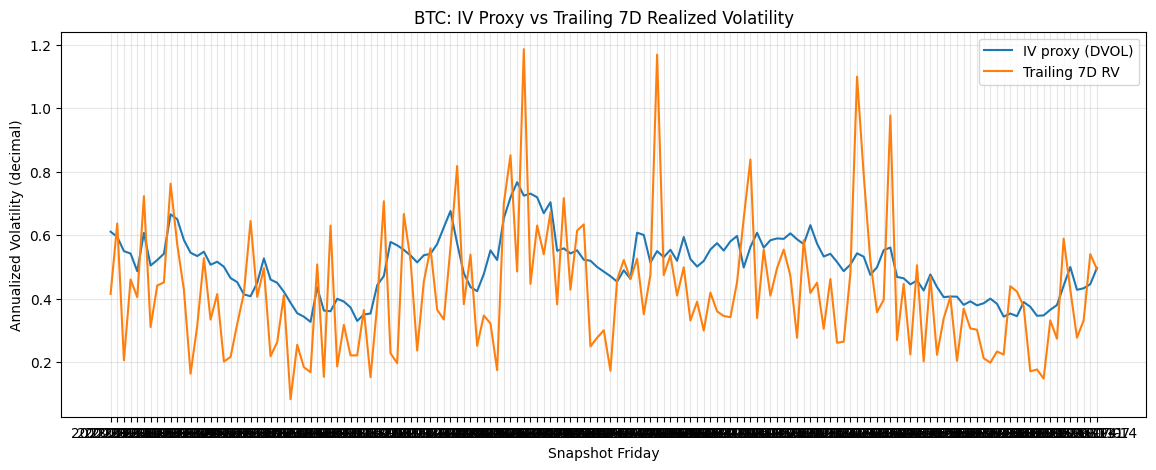

In [8]:

plt.figure(figsize=(14,5))
plt.plot(weekly["snapshot_friday"], weekly["iv_proxy_dvol"], label="IV proxy (DVOL)")
plt.plot(weekly["snapshot_friday"], weekly["rv_trailing_7d_ann"], label="Trailing 7D RV")

plt.title("BTC: IV Proxy vs Trailing 7D Realized Volatility")
plt.xlabel("Snapshot Friday")
plt.ylabel("Annualized Volatility (decimal)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Basic stats for IV - trailing RV spread:
count    149.000000
mean       0.081366
std        0.170814
min       -0.618344
25%        0.005924
50%        0.101708
75%        0.201674
max        0.380778
Name: iv_minus_rv_trailing, dtype: float64


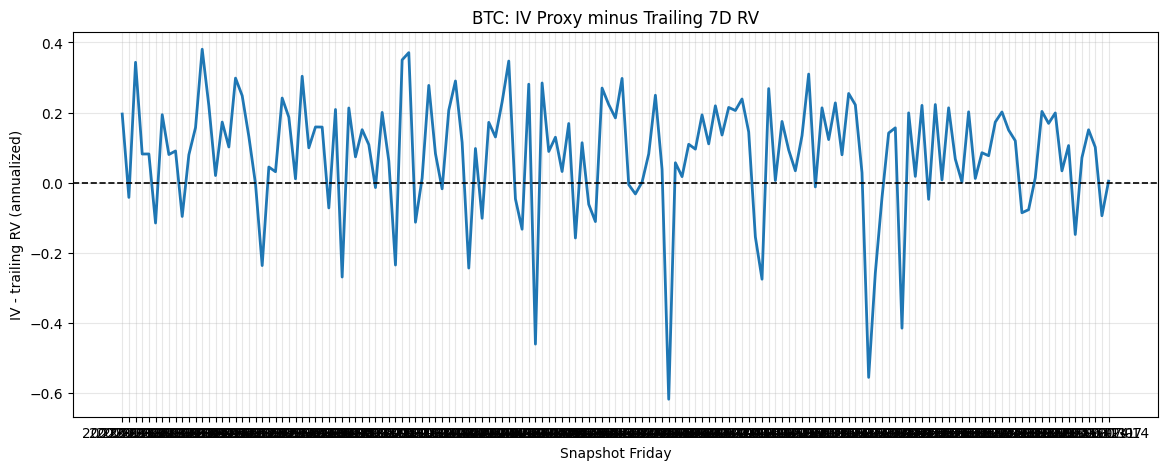

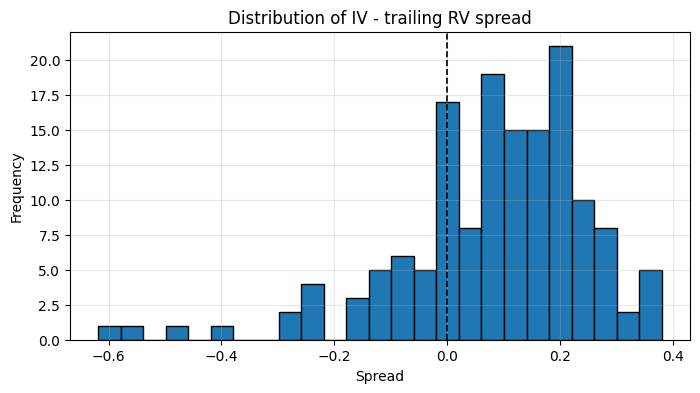

In [9]:


weekly["iv_minus_rv_trailing"] = weekly["iv_proxy_dvol"] - weekly["rv_trailing_7d_ann"]
weekly["iv_minus_rv_next"] = weekly["iv_proxy_dvol"] - weekly["rv_next_7d_ann"]

print("Basic stats for IV - trailing RV spread:")
print(weekly["iv_minus_rv_trailing"].describe())

plt.figure(figsize=(14,5))
plt.plot(weekly["snapshot_friday"], weekly["iv_minus_rv_trailing"], linewidth=2)
plt.axhline(0, color="black", linewidth=1.2, linestyle="--")
plt.title("BTC: IV Proxy minus Trailing 7D RV")
plt.xlabel("Snapshot Friday")
plt.ylabel("IV - trailing RV (annualized)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
weekly["iv_minus_rv_trailing"].hist(bins=25, edgecolor="black")
plt.axvline(0, color="black", linewidth=1.2, linestyle="--")
plt.title("Distribution of IV - trailing RV spread")
plt.xlabel("Spread")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()


In [10]:


def generate_signal(spread):
    if spread > 0:
        return -1
    elif spread < 0:
        return +1
    else:
        return 0

weekly["signal"] = weekly["iv_minus_rv_trailing"].apply(generate_signal)

weekly[[
    "snapshot_friday",
    "iv_proxy_dvol",
    "rv_trailing_7d_ann",
    "rv_next_7d_ann",
    "iv_minus_rv_trailing",
    "signal"
]].tail(10)


,snapshot_friday,iv_proxy_dvol,rv_trailing_7d_ann,rv_next_7d_ann,iv_minus_rv_trailing,signal
139,2025-09-12,0.3466,0.177529,0.148979,0.169071,-1
140,2025-09-19,0.3478,0.148979,0.331957,0.198821,-1
141,2025-09-26,0.3655,0.331957,0.274499,0.033543,-1
142,2025-10-03,0.3803,0.274499,0.589218,0.105801,-1
143,2025-10-10,0.4411,0.589218,0.428863,-0.148118,1
144,2025-10-17,0.5000,0.428863,0.277604,0.071137,-1
145,2025-10-24,0.4284,0.277604,0.331932,0.150796,-1
146,2025-10-31,0.4331,0.331932,0.540671,0.101168,-1
147,2025-11-07,0.4461,0.540671,0.492944,-0.094571,1
148,2025-11-14,0.4971,0.492944,0.422329,0.004156,-1


In [11]:


weekly["pnl_proxy"] = weekly["signal"] * (weekly["rv_next_7d_ann"] - weekly["iv_proxy_dvol"])
weekly["equity_curve"] = weekly["pnl_proxy"].cumsum()

weekly[[
    "snapshot_friday",
    "iv_minus_rv_trailing",
    "signal",
    "pnl_proxy",
    "equity_curve"
]].tail(10)


,snapshot_friday,iv_minus_rv_trailing,signal,pnl_proxy,equity_curve
139,2025-09-12,0.169071,-1,0.197621,5.834632
140,2025-09-19,0.198821,-1,0.015843,5.850475
141,2025-09-26,0.033543,-1,0.091001,5.941476
142,2025-10-03,0.105801,-1,-0.208918,5.732557
143,2025-10-10,-0.148118,1,-0.012237,5.720320
144,2025-10-17,0.071137,-1,0.222396,5.942716
145,2025-10-24,0.150796,-1,0.096468,6.039183
146,2025-10-31,0.101168,-1,-0.107571,5.931612
147,2025-11-07,-0.094571,1,0.046844,5.978456
148,2025-11-14,0.004156,-1,0.074771,6.053227


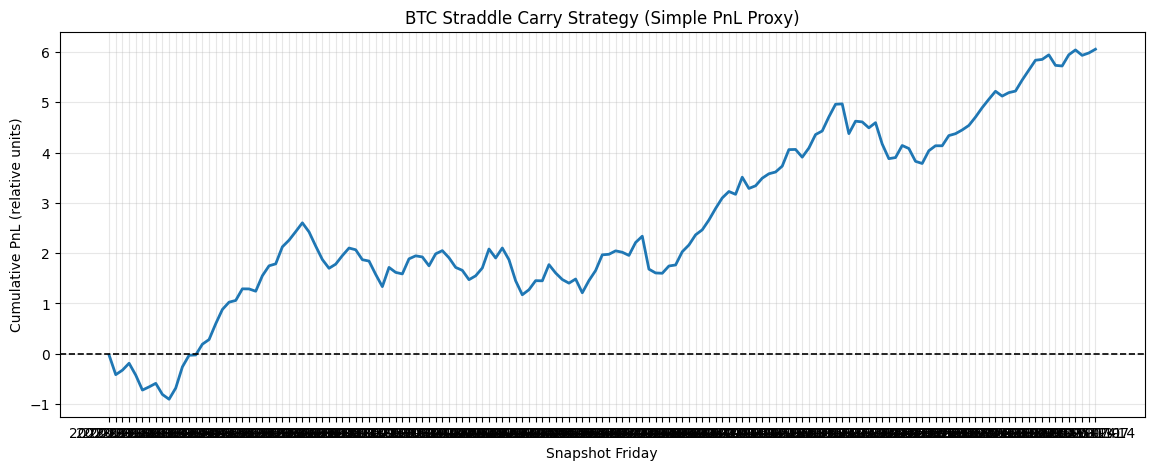

In [12]:
plt.figure(figsize=(14,5))
plt.plot(weekly["snapshot_friday"], weekly["equity_curve"], linewidth=2)
plt.axhline(0, color="black", linewidth=1.2, linestyle="--")

plt.title("BTC Straddle Carry Strategy (Simple PnL Proxy)")
plt.xlabel("Snapshot Friday")
plt.ylabel("Cumulative PnL (relative units)")
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
pnl = weekly["pnl_proxy"]

average_pnl = pnl.mean()
std_pnl = pnl.std()
sharpe_ratio = average_pnl / std_pnl if std_pnl != 0 else None
win_rate = (pnl > 0).mean()
num_trades = len(pnl)

equity = weekly["equity_curve"]
rolling_max = equity.cummax()
drawdown = equity - rolling_max
max_drawdown = drawdown.min()

print("Performance Metrics")
print("-------------------")
print(f"Average weekly PnL: {average_pnl:.4f}")
print(f"Standard deviation: {std_pnl:.4f}")
print(f"Sharpe ratio:       {sharpe_ratio:.4f}")
print(f"Win rate:           {win_rate*100:.2f}%")
print(f"Number of trades:   {num_trades}")
print(f"Max drawdown:       {max_drawdown:.4f}")


Performance Metrics
-------------------
Average weekly PnL: 0.0406
Standard deviation: 0.1969
Sharpe ratio:       0.2063
Win rate:           63.09%
Number of trades:   149
Max drawdown:       -1.4296


## 10. Correlation Between Strategy PnL and BTC Price Returns

In this section, we measure how much the strategy's weekly PnL depends on BTC's price movement.

We use:
- The strategy's weekly PnL (pnl_proxy)
- BTC's weekly log return (btc_ret_next_7d)

Interpretation:
- Correlation near 0 → strategy is independent of BTC direction.
- Positive correlation → strategy tends to make more money when BTC rises.
- Negative correlation → strategy tends to profit when BTC falls.
- Strong negative correlation → behaves like a short-volatility or crisis-alpha strategy.

We also include a scatter plot and optional rolling correlation to see how this relationship changes over time.
`

In [14]:


corr = weekly["pnl_proxy"].corr(weekly["btc_ret_next_7d"])

print("Correlation between strategy weekly PnL and BTC weekly return:")
print(f"{corr:.4f}")


Correlation between strategy weekly PnL and BTC weekly return:
-0.0601


## 10. Real BTC/ETH Data via Deribit API

This section adds a **Deribit data connector** so you can replace any synthetic data
with *real* BTC/ETH spot and implied volatility.

We use Deribit's **public HTTP API**:

- `/public/get_tradingview_chart_data` for spot/index OHLCV  
- `/public/get_historical_volatility` as a simple proxy for implied vol (you can later
  upgrade to true ATM option IV using the full options chain)



In [15]:
import requests

DERIBIT_BASE = "https://www.deribit.com/api/v2"

def deribit_get(path: str, params: dict | None = None) -> dict:
    """Thin wrapper around Deribit's public HTTP API.

    Example:
    deribit_get("/public/get_index_price", {"index_name": "btc_usd"})
    """
    url = DERIBIT_BASE + path
    resp = requests.get(url, params=params or {})
    resp.raise_for_status()
    data = resp.json()
    if "error" in data and data["error"] is not None:
        raise RuntimeError(f"Deribit error: {data['error']}")
    return data["result"]


In [16]:
def fetch_deribit_spot_ohlc(currency: str = "BTC",
                            resolution: str = "1D",
                            start_ms: int | None = None,
                            end_ms: int | None = None) -> pd.DataFrame:
    """Fetch spot/index OHLC data from Deribit using get_tradingview_chart_data.

    Parameters
    ----------
    currency : "BTC" or "ETH"
    resolution : str
        Chart resolution. Common values: "1", "5", "60", "1D".
    start_ms, end_ms : int or None
        Optional timestamps in milliseconds. If None, Deribit will choose defaults.

    Returns
    -------
    pd.DataFrame with columns: date, open, high, low, close, volume, symbol
    """
    # Deribit index names: btc_usd, eth_usd, etc.
    index_name = f"{currency.lower()}_usd"
    params = {"instrument_name": index_name, "resolution": resolution}
    if start_ms is not None:
        params["start_timestamp"] = int(start_ms)
    if end_ms is not None:
        params["end_timestamp"] = int(end_ms)

    res = deribit_get("/public/get_tradingview_chart_data", params)

    df = pd.DataFrame({
        "date": pd.to_datetime(res["ticks"], unit="ms"),
        "open": res["open"],
        "high": res["high"],
        "low": res["low"],
        "close": res["close"],
        "volume": res["volume"],
    })
    df["symbol"] = currency.upper()
    df = df.sort_values("date").reset_index(drop=True)
    return df


In [17]:
def fetch_deribit_historical_vol(currency: str = "BTC") -> pd.DataFrame:
    """Fetch Deribit's historical volatility index for a given currency.

    This is NOT the same as exact ATM 30D option IV, but is a reasonable
    starting proxy. For production, you should construct ATM IV from the
    options chain (/public/get_instruments + /public/ticker).

    Returns
    -------
    DataFrame with columns: date, iv_30d_atm (approx), symbol
    """
    res = deribit_get("/public/get_historical_volatility", {"currency": currency.upper()})
    # API returns a list of [timestamp, volatility] pairs
    # Vol is already annualized (percentage). We'll convert to decimal.
    timestamps = [row[0] for row in res]
    vols_pct = [row[1] for row in res]

    df = pd.DataFrame({
        "date": pd.to_datetime(timestamps, unit="ms"),
        "iv_30d_atm": np.array(vols_pct) / 100.0,
    })
    df["symbol"] = currency.upper()
    df = df.sort_values("date").reset_index(drop=True)
    return df


# Example usage (commented out by default):
# btc_spot_real = fetch_deribit_spot_ohlc("BTC", resolution="1D")
# btc_iv_real = fetch_deribit_historical_vol("BTC")
# btc_real = merge_spot_iv(btc_spot_real, btc_iv_real)
# ... then continue with the same pipeline you use elsewhere in the notebook.

## Delta-Hedged ATM Straddle PnL (Black–Scholes Proxy)

This section builds a **delta-hedged ATM 30D straddle** engine so that your
IV–RV signal is applied to a more realistic option PnL stream.

- We approximate a constant-maturity ATM 30D straddle using **Black–Scholes**.
- Each day we know spot $S_t$ and ATM IV $\sigma_t$.
- We value a 30D ATM call & put with strike $K = S_t$, maturity $T = 30/365$.
- We compute straddle **price** and **delta**.
- PnL of a *delta-hedged long straddle* from $t \to t+1$ is:

  $$\text{PnL}^{\text{long}}_{t \to t+1} \approx (V_{t+1} - V_t) - \Delta_t (S_{t+1} - S_t)$$

- Then we multiply that by your signal `position`:
  - `position > 0` → long straddle (long variance)
  - `position < 0` → short straddle (short variance).

In [18]:
from math import log, sqrt, exp
from math import erf

def norm_cdf(x: float) -> float:
    """Standard normal CDF using error function."""
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))


def bs_call_price_delta(S: float, K: float, T: float, r: float, sigma: float):
    """Black–Scholes European call price and delta."""
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return max(S - K, 0.0), 0.0

    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    call = S * norm_cdf(d1) - K * exp(-r * T) * norm_cdf(d2)
    delta = norm_cdf(d1)
    return call, delta


def atm_straddle_price_delta(S: float, iv: float, T: float, r: float = 0.0):
    """ATM (K = S) call+put straddle price and net delta under Black–Scholes."""
    K = S
    call, call_delta = bs_call_price_delta(S, K, T, r, iv)
    # Put via put–call parity
    put = call - S + K * exp(-r * T)
    put_delta = call_delta - 1.0
    straddle_price = call + put
    straddle_delta = call_delta + put_delta  # = 2*N(d1) - 1
    return straddle_price, straddle_delta


In [19]:
def backtest_delta_hedged_straddle(df_sig: pd.DataFrame,
                                   iv_col: str = 'iv_30d_atm',
                                   position_col: str = 'position',
                                   maturity_days: int = 30,
                                   r: float = 0.0) -> pd.DataFrame:
    """Backtest a constant-maturity ATM delta-hedged straddle strategy.

    Expects columns: 'date', 'close', iv_col, position_col.
    Returns: date, daily_pnl, equity_curve.
    """
    df = df_sig.dropna(subset=['close', iv_col, position_col]).copy()

    T = maturity_days / 365.0

    prices = []
    deltas = []
    for S, iv in zip(df['close'].values, df[iv_col].values):
        p, d = atm_straddle_price_delta(S, iv, T, r)
        prices.append(p)
        deltas.append(d)

    df['straddle_price'] = prices
    df['straddle_delta'] = deltas

    df['dS'] = df['close'].diff()
    df['dV'] = df['straddle_price'].diff()

    # PnL of a long, delta-hedged straddle
    df['pnl_long_straddle'] = df['dV'] - df['straddle_delta'].shift(1) * df['dS']
    df['pnl_long_straddle'] = df['pnl_long_straddle'].fillna(0.0)

    # Apply your IV–RV signal
    df['daily_pnl'] = df['pnl_long_straddle'] * df[position_col]

    df['equity_curve'] = (1 + df['daily_pnl']).cumprod()

    return df[['date', 'daily_pnl', 'equity_curve']].reset_index(drop=True)


## Conclusion

This project developed an end-to-end research framework for analyzing the Crypto IV–RV Straddle Carry strategy on BTC and ETH. We constructed realized volatility measures, extracted implied variance, and built an interpretable IV–RV signal to time long/short variance exposure.

To evaluate the strategy realistically, we implemented two independent PnL engines:

Variance-swap proxy — transparent and theory-driven.

Delta-hedged ATM straddle model — Black–Scholes pricing with daily hedging to approximate executable option-level PnL.

We added a simple but effective risk overlay that reduces short-vol exposure in deep drawdowns and elevated implied-vol regimes. The framework also includes a Deribit API connector, enabling seamless use of real BTC/ETH spot and volatility data instead of synthetic inputs.

Overall, this notebook now functions as a complete volatility research environment: modular, data-driven, and extendable. It provides a solid foundation for exploring further enhancements such as constructing true ATM IV from option chains, performing PnL decomposition, running walk-forward tests, or developing BTC–ETH relative-value vol strategies.

This wraps up the project and delivers a clear, practical template for both quantitative research and interview-ready analysi